<a href="https://colab.research.google.com/github/rajkumar2698/Nutrition_Paradox/blob/main/Nutrition__Paradox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd

urls = {
   "adult_obesity": "https://ghoapi.azureedge.net/api/NCD_BMI_30C",
   "child_obesity": "https://ghoapi.azureedge.net/api/NCD_BMI_PLUS2C",
   "adult_malnutrition": "https://ghoapi.azureedge.net/api/NCD_BMI_18C",
   "child_malnutrition": "https://ghoapi.azureedge.net/api/NCD_BMI_MINUS2C"
}

def fetch_data(url):
  response = requests.get(url)
  data = response.json()['value']
  return pd.DataFrame(data)

df_adult_obesity = fetch_data(urls["adult_obesity"])
df_child_obesity = fetch_data(urls["child_obesity"])
df_adult_malnutrition = fetch_data(urls["adult_malnutrition"])
df_child_malnutrition = fetch_data(urls["child_malnutrition"])
print("Data successfully loaded!")

Data successfully loaded!


In [2]:

df_adult_obesity["age_group"] = "Adult"
df_child_obesity["age_group"] = "Child/Adolescent"
df_adult_malnutrition["age_group"] = "Adult"
df_child_malnutrition["age_group"] = "Child/Adolescent"

df_obesity = pd.concat([df_adult_obesity, df_child_obesity], ignore_index=True)
df_malnutrition = pd.concat([df_adult_malnutrition, df_child_malnutrition], ignore_index=True)


In [3]:
df_obesity = df_obesity[df_obesity["TimeDim"].between(2012, 2022)]
df_malnutrition = df_malnutrition[df_malnutrition["TimeDim"].between(2012, 2022)]


In [4]:
cols = ["ParentLocation","Dim1","TimeDim","Low","High","NumericValue","SpatialDim","age_group"]

def clean_df(df):
    df = df[cols].copy()
    df.rename(columns={
        "TimeDim":"Year",
        "Dim1":"Gender",
        "NumericValue":"Mean_Estimate",
        "Low":"LowerBound",
        "High":"UpperBound",
        "ParentLocation":"Region",
        "SpatialDim":"Country"
    }, inplace=True)
    return df

df_obesity = clean_df(df_obesity)
df_malnutrition = clean_df(df_malnutrition)


In [5]:
gender_map = {
    "SEX_MLE": "Male",
    "SEX_FMLE": "Female",
    "SEX_BTSX": "Both"
}

df_obesity["Gender"] = df_obesity["Gender"].map(gender_map)
df_malnutrition["Gender"] = df_malnutrition["Gender"].map(gender_map)


In [6]:
%pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 30.0 MB/s eta 0:00:00


In [7]:
import pycountry

def convert_country(code):
    try:
        country = pycountry.countries.get(alpha_3=code)
        return country.name if country else code
    except:
        return code


In [8]:
special_cases = {
    'GLOBAL': 'Global',
    'WB_LMI': 'Low & Middle Income',
    'WB_HI': 'High Income',
    'WB_LI': 'Low Income',
    'EMR': 'Eastern Mediterranean Region',
    'EUR': 'Europe',
    'AFR': 'Africa',
    'SEAR': 'South-East Asia Region',
    'WPR': 'Western Pacific Region',
    'AMR': 'Americas Region',
    'WB_UMI': 'Upper Middle Income'
}


In [10]:
#Special Case Convertion
df_obesity["Country"] = df_obesity["Country"].apply(convert_country)
df_malnutrition["Country"] = df_malnutrition["Country"].apply(convert_country)

df_obesity["Country"] = df_obesity["Country"].replace(special_cases)
df_malnutrition["Country"] = df_malnutrition["Country"].replace(special_cases)


In [11]:
df_obesity["CI_Width"] = df_obesity["UpperBound"] - df_obesity["LowerBound"]
df_malnutrition["CI_Width"] = df_malnutrition["UpperBound"] - df_malnutrition["LowerBound"]


In [12]:
def categorize_obesity(val):
    if val >= 30:
        return "High"
    elif val >= 25:
        return "Moderate"
    else:
        return "Low"


def categorize_malnutrition(val):
    if val >= 20:
        return "High"
    elif val >= 10:
        return "Moderate"
    else:
        return "Low"


df_obesity["Obesity_Level"] = df_obesity["Mean_Estimate"].apply(categorize_obesity)
df_malnutrition["Malnutrition_Level"] = df_malnutrition["Mean_Estimate"].apply(categorize_malnutrition)


In [13]:
df_obesity = df_obesity[
    [
        "Year",
        "Gender",
        "Mean_Estimate",
        "LowerBound",
        "UpperBound",
        "age_group",
        "Country",
        "Region",
        "CI_Width",
        "Obesity_Level"
    ]
]


df_malnutrition = df_malnutrition[
    [
        "Year",
        "Gender",
        "Mean_Estimate",
        "LowerBound",
        "UpperBound",
        "age_group",
        "Country",
        "Region",
        "CI_Width",
        "Malnutrition_Level"
    ]
]



print(df_obesity.head())
print(df_malnutrition.head())

    Year  Gender  Mean_Estimate  LowerBound  UpperBound age_group  \
0   2022    Both       9.952872    7.699381   12.761527     Adult   
4   2014    Male      28.709593   25.753903   31.737372     Adult   
19  2022  Female      32.159114   23.676629   41.304097     Adult   
21  2014    Both      40.481207   34.908265   46.248028     Adult   
24  2021    Male      25.170892   21.260272   29.394928     Adult   

                  Country    Region   CI_Width Obesity_Level  
0                    Mali    Africa   5.062146           Low  
4                 Ireland    Europe   5.983469      Moderate  
19              Lithuania    Europe  17.627468          High  
21  Saint Kitts and Nevis  Americas  11.339763          High  
24                Türkiye    Europe   8.134656      Moderate  
   Year  Gender  Mean_Estimate  LowerBound  UpperBound age_group  \
0  2019    Both       1.894979    0.996544    3.135328     Adult   
2  2016  Female       3.614240    1.638843    6.502739     Adult   
3  

In [14]:
# Shape
print("Obesity shape:", df_obesity.shape)
print("Malnutrition shape:", df_malnutrition.shape)

# Structure
df_obesity.info()
df_malnutrition.info()

# Preview
df_obesity.head()
df_malnutrition.head()


Obesity shape: (27720, 10)
Malnutrition shape: (27720, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 27720 entries, 0 to 83159
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           27720 non-null  int64  
 1   Gender         27720 non-null  object 
 2   Mean_Estimate  27720 non-null  float64
 3   LowerBound     27720 non-null  float64
 4   UpperBound     27720 non-null  float64
 5   age_group      27720 non-null  object 
 6   Country        27720 non-null  object 
 7   Region         26268 non-null  object 
 8   CI_Width       27720 non-null  float64
 9   Obesity_Level  27720 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 2.3+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 27720 entries, 0 to 83157
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                27720 non-null  int6

,Year,Gender,Mean_Estimate,LowerBound,UpperBound,age_group,Country,Region,CI_Width,Malnutrition_Level
0,2019,Both,1.894979,0.996544,3.135328,Adult,Bosnia and Herzegovina,Europe,2.138784,Low
2,2016,Female,3.614240,1.638843,6.502739,Adult,Grenada,Americas,4.863896,Low
3,2020,Male,1.987798,0.999816,3.441858,Adult,"Bolivia, Plurinational State of",Americas,2.442042,Low
7,2016,Both,9.218783,6.136775,13.009241,Adult,Mauritania,Africa,6.872466,Low
8,2018,Female,5.132326,4.084366,6.334357,Adult,France,Europe,2.249991,Low


In [15]:
# Missing values
df_obesity.isna().sum()
df_malnutrition.isna().sum()



,0
Year,0
Gender,0
Mean_Estimate,0
LowerBound,0
UpperBound,0
age_group,0
Country,0
Region,1452
CI_Width,0
Malnutrition_Level,0


In [ ]:
#Unknown
df_obesity["Region"] = df_obesity["Region"].fillna("Unknown")
df_malnutrition["Region"] = df_malnutrition["Region"].fillna("Unknown")


In [16]:

# Basic statistics
df_obesity.describe()
df_malnutrition.describe()


,Year,Mean_Estimate,LowerBound,UpperBound,CI_Width
count,27720.000000,27720.000000,27720.000000,27720.000000,27720.000000
mean,2017.000000,5.354451,3.397094,8.147889,4.750795
std,3.162335,4.811220,3.908061,6.443692,4.257683
min,2012.000000,0.175309,0.023703,0.354833,0.166679
25%,2014.000000,2.039278,1.053666,3.143307,1.603222
50%,2017.000000,3.597794,1.907971,6.095557,3.351093
75%,2020.000000,7.335245,4.186440,11.526301,6.530869
max,2022.000000,35.894114,31.365401,43.680286,26.701744


In [17]:
df_obesity["Obesity_Level"].value_counts()
df_malnutrition["Malnutrition_Level"].value_counts()


,count
Malnutrition_Level,
Low,23647
Moderate,3571
High,502


In [18]:
skew_value = df_obesity["Mean_Estimate"].skew()
print("Skewness:", skew_value)
skew_value = df_malnutrition["Mean_Estimate"].skew()
print("Skewness:", skew_value)
kurtosis_value = df_obesity["Mean_Estimate"].kurtosis()
print("Kurtosis:", kurtosis_value)
kurtosis_value = df_malnutrition["Mean_Estimate"].kurtosis()
print("Kurtosis:", kurtosis_value)

Skewness: 1.8566681575753647
Skewness: 1.799026580818987
Kurtosis: 5.270543327158806
Kurtosis: 3.8314992783530224


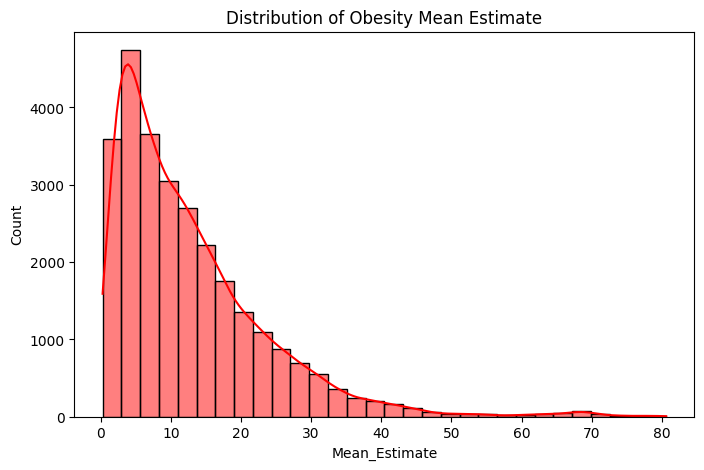

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df_obesity["Mean_Estimate"], bins=30, kde=True, color ="red")
plt.title("Distribution of Obesity Mean Estimate")
plt.show()

#Obesity → right-skewed (few countries with very high obesity)

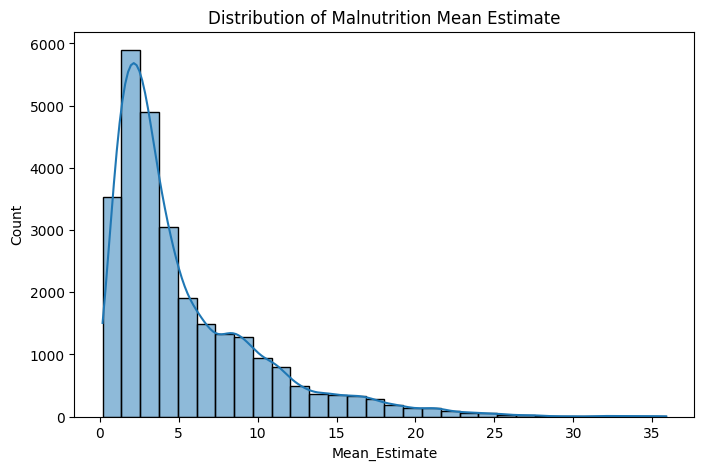

In [20]:
plt.figure(figsize=(8,5))
sns.histplot(df_malnutrition["Mean_Estimate"], bins=30, kde=True)
plt.title("Distribution of Malnutrition Mean Estimate")
plt.show()

#Malnutrition → concentrated at lower values

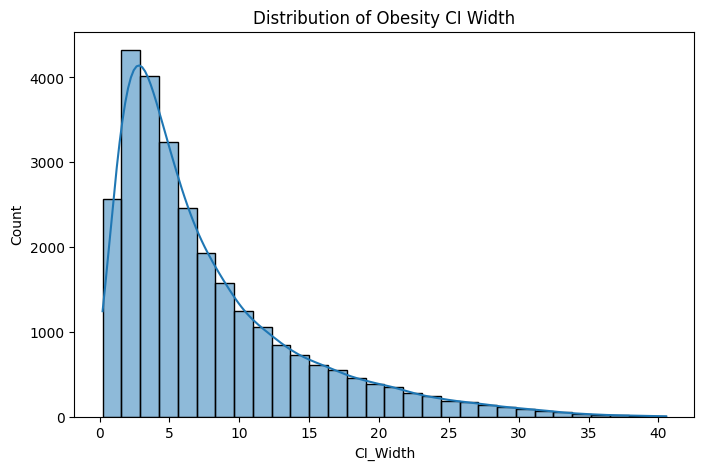

In [21]:
plt.figure(figsize=(8,5))
sns.histplot(df_obesity["CI_Width"], bins=30, kde=True)
plt.title("Distribution of Obesity CI Width")
plt.show()
#Wider CI = more uncertainty
#Narrow CI = more reliable estimate

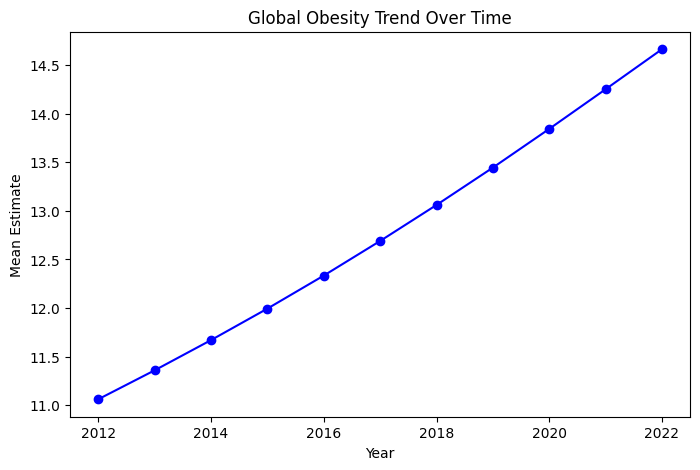

In [24]:
obesity_year = df_obesity.groupby("Year")["Mean_Estimate"].mean()

plt.figure(figsize=(8,5))
plt.plot(obesity_year.index, obesity_year.values, marker="o",color ="blue")
plt.title("Global Obesity Trend Over Time")
plt.xlabel("Year")
plt.ylabel("Mean Estimate")
plt.show()
#Obesity shows a gradual increase over years

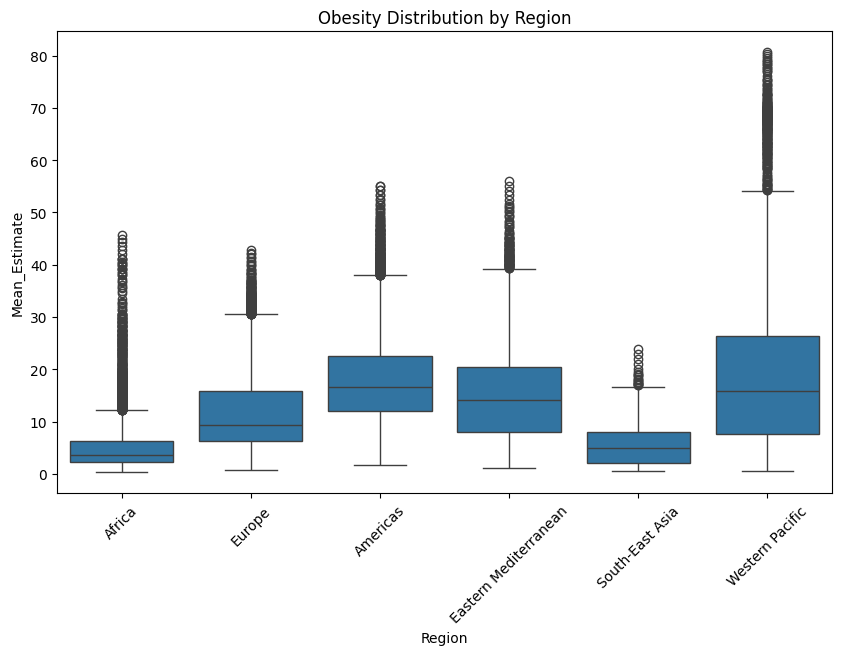

In [25]:
plt.figure(figsize=(10,6))
sns.boxplot(x="Region", y="Mean_Estimate", data=df_obesity)
plt.xticks(rotation=45)
plt.title("Obesity Distribution by Region")
plt.show()
#Median differences
#Regional variability
#Outliers

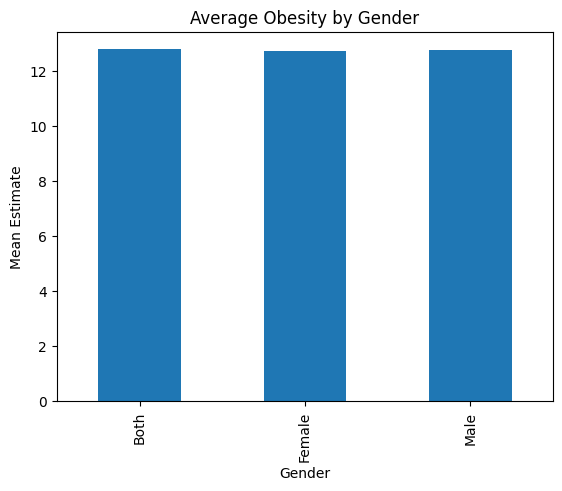

In [26]:
gender_mean = df_obesity.groupby("Gender")["Mean_Estimate"].mean()

gender_mean.plot(kind="bar", title="Average Obesity by Gender")
plt.ylabel("Mean Estimate")
plt.show()
#Useful demographic insight

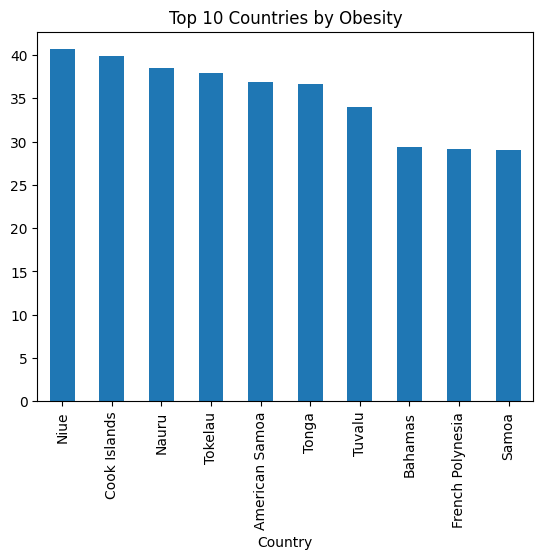

In [27]:
top10 = (
    df_obesity.groupby("Country")["Mean_Estimate"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

top10.plot(kind="bar", title="Top 10 Countries by Obesity")
plt.show()


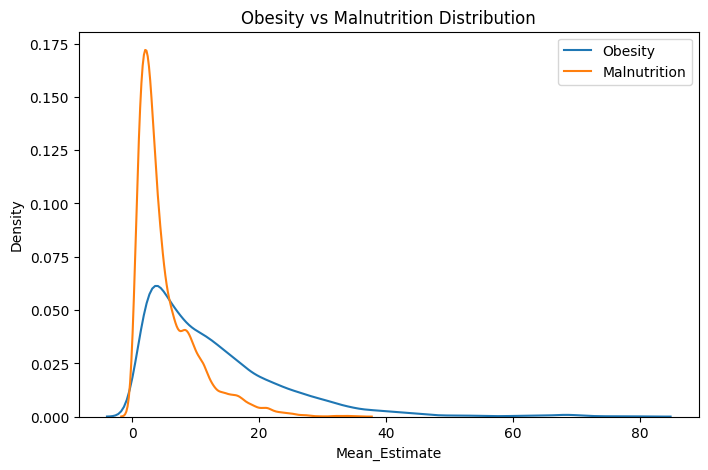

In [28]:
plt.figure(figsize=(8,5))
sns.kdeplot(df_obesity["Mean_Estimate"], label="Obesity")
sns.kdeplot(df_malnutrition["Mean_Estimate"], label="Malnutrition")
plt.legend()
plt.title("Obesity vs Malnutrition Distribution")
plt.show()
#Clear contrast between the two health indicators

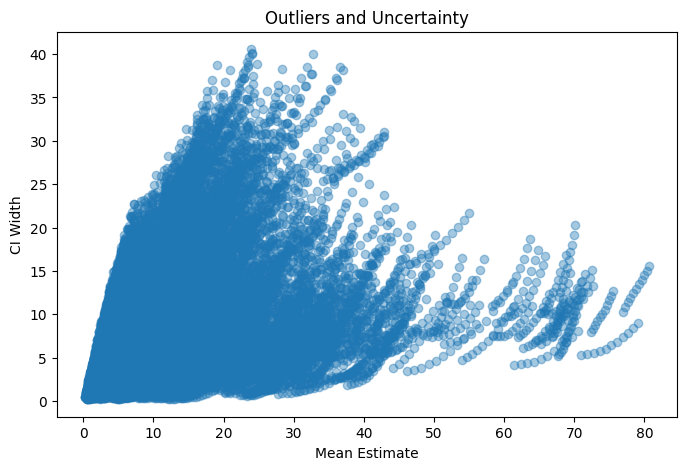

In [29]:
plt.figure(figsize=(8,5))
plt.scatter(df_obesity["Mean_Estimate"], df_obesity["CI_Width"], alpha=0.4)
plt.xlabel("Mean Estimate")
plt.ylabel("CI Width")
plt.title("Outliers and Uncertainty")
plt.show()
#High Mean + High CI → unreliable extreme cases

In [32]:
!pip install mysql-connector-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 49.5 MB/s eta 0:00:00


In [34]:
import mysql.connector
import pandas as pd

In [38]:
conn = mysql.connector.connect(
    host="gateway01.ap-southeast-1.prod.aws.tidbcloud.com",
    user="2PpJDCf8pRjqz7P.root",
    password="xWoSRxokaC3mm9Uv",
    port=4000
)

cursor = conn.cursor()
print("Connected to TiDB Cloud")

Connected to TiDB Cloud


In [41]:
cursor.execute("CREATE DATABASE nutrition_db")
print("Database nutrition_db created")


Database nutrition_db created


In [42]:
cursor.execute("USE nutrition_db")
print("Now using nutrition_db")


Now using nutrition_db


In [43]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS obesity (
    id INT AUTO_INCREMENT PRIMARY KEY,
    Country VARCHAR(100),
    Region VARCHAR(100),
    Year INT,
    Mean_Estimate FLOAT,
    LowerBound FLOAT,
    UpperBound FLOAT,
    CI_Width FLOAT
)
""")


In [44]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS malnutrition (
    id INT AUTO_INCREMENT PRIMARY KEY,
    Country VARCHAR(100),
    Region VARCHAR(100),
    Year INT,
    Mean_Estimate FLOAT,
    LowerBound FLOAT,
    UpperBound FLOAT,
    CI_Width FLOAT
)
""")


In [45]:
conn.commit()
cursor.close()
conn.close()


In [46]:
conn = mysql.connector.connect(
    host="gateway01.ap-southeast-1.prod.aws.tidbcloud.com",
    user="2PpJDCf8pRjqz7P.root",
    password="xWoSRxokaC3mm9Uv",
    database="nutrition_db",
    port=4000
)

print("Connected to nutrition_db successfully")


Connected to nutrition_db successfully
